# Reader Implementation Tutorial

This notebook is designed to guide you through the process of creating a reader function for raw data files generated by a disdrometer device.

The tutorial is divided into two parts:

1. reading and exploring the raw data files

2. developing and validating the reader function

Once finalized and integrated into the disdrodb software, the reader function will enable the ingestion of your raw data files into the DISDRODB processing pipeline.

If you arrived at this tutorial from the [How to Contribute New Data to DISDRODB](https://disdrodb.readthedocs.io/en/latest/contribute_data.html) documentation, you should have already completed the following steps: 

* defined the metadata for the stations for which you aim to define the reader, including the ``raw_data_glob_pattern`` attribute;
* copied the raw data files into the appropriate folder within your local DISDRODB archive;
* copied the [template_reader_raw_text_data.py](https://github.com/ltelab/disdrodb/blob/main/disdrodb/l0/readers/template_reader_raw_text_data.py), placed it in the appropriate `disdrodb.l0.readers.<SENSOR_NAME>.<DATA_SOURCE>` directory and renamed it to `<READER_NAME>.py`.
* updated the metadata `reader` attribute with the reader reference `<DATA_SOURCE>/<READER_NAME>`, which points the disdrodb software to the reader you will develop in this tutorial.


We highly recommend starting with this notebook using the lightweight example dataset provided for demonstration purposes.
Once you are familiar with the workflow, you can adapt the notebook to explore your own raw data and build a custom reader function for your station(s).



For this tutorial, we use sample data available in the [data/DISDRODB](https://github.com/ltelab/disdrodb/tree/main/data/DISDRODB) directory of the [disdrodb](https://github.com/ltelab/disdrodb/) repository. These data include a two days subset of OTT Parsivel disdrometer measurements collected in the garden of the Radar, Satellite and Nowcasting division of MeteoSwiss, in Locarno, Switzerland. The metadata of the station (named `61`) is already included in the DISDRODB Metadata Archive.

To start the tutorial, we copy the sample stations data to a temporary local DISDRODB Data Archive:

In [ ]:
import os
import shutil

import disdrodb

# Define the path to the temporary local DISDRODB Data Archive
tutorial_data_archive_dir = "/tmp/data/DISDRODB"

In [ ]:
# Copy the example data archive to the tutorial local DISDRODB Data Archive
root_path = os.path.dirname(os.getcwd())  # software root path
example_data_archive_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "DISDRODB")
shutil.copytree(example_data_archive_dir, tutorial_data_archive_dir)

'/tmp/data/DISDRODB'

The created local DISDRODB Data Archive have the following structure:
```
  📁 DISDRODB
  ├── 📁 RAW
      ├── 📁 EPFL
          ├── 📁 LOCARNO_2018
              ├── 📁 data
                  ├── 📁 61
                  ├── 📜 file61_20180817.dat.gz
                  ├── 📜 file61_20180818.dat.gz
             
```

You can open the station raw data directory calling the python function ``open_product_directory``:  

In [ ]:
disdrodb.open_product_directory(
    data_archive_dir=tutorial_data_archive_dir,
    product="RAW",
    data_source="EPFL",
    campaign_name="LOCARNO_2018",
    station_name="61",
)

Let's also check that the DISDRODB Metadata Archive has been specified correctly in the DISDRODB configuration file.

If calling the following cell raise an error, please check again the steps described in the [Quick Start](https://disdrodb.readthedocs.io/en/latest/quick_start.html) section of the software documentation on how to download the DISDRODB Metadata Archive and set up the DISDRODB configuration file !


In [ ]:
metadata_archive_dir = disdrodb.get_metadata_archive_dir()
print(metadata_archive_dir)

/home/ghiggi/Projects/DISDRODB-METADATA/DISDRODB


Now we are ready to start the tutorial and define the DISDRODB reader required to process the raw data files and create DISDRODB products.

The goal is to define a function accepting a file path and returning a pandas dataframe compliant with the DISDRODB L0 standards.

Let's start by importing the required packages and modules.

In [ ]:
from pprint import pprint

import pandas as pd
from IPython.display import display

import disdrodb
from disdrodb.api.checks import check_sensor_name
from disdrodb.l0.check_standards import check_l0a_column_names
from disdrodb.l0.l0a_processing import (
    generate_l0a,
    read_raw_text_file,
    sanitize_df,
)
from disdrodb.l0.l0b_processing import generate_l0b
from disdrodb.l0.template_tools import (
    check_column_names,
    get_df_columns_unique_values_dict,
    infer_column_names,
    print_allowed_column_names,
    print_df_column_names,
    print_df_columns_unique_values,
    print_df_first_n_rows,
    print_df_random_n_rows,
)
from disdrodb.utils.time import infer_sample_interval

## 1. Define station metadata and list raw data files

Here below we define the station arguments required to search the metadata in the DISDRODB Metadata Archive
and the raw data files in the local DISDRODB Data Archive.

When developing your own reader, you should adapt these station arguments to your own station.

In [ ]:
data_source = "EPFL"
campaign_name = "LOCARNO_2018"
station_name = "61"

With the following function we can easily read the metadata of the station
present in the DISDRODB Metadata Archive. 

In [ ]:
metadata = disdrodb.read_station_metadata(
    metadata_archive_dir=metadata_archive_dir,
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)
pprint(metadata)

{'acknowledgement': '',
 'altitude': 369,
 'authors': 'Alexis Berne, Jacopo Grazioli',
 'authors_url': 'https://orcid.org/0000-0003-4977-1204, '
                'https://orcid.org/0000-0002-7097-3946',
 'calibration_certification_date': '',
 'calibration_certification_url': '',
 'calibration_sensitivity': '',
 'campaign_name': 'LOCARNO_2018',
 'comment': 'Instrument installed at the MeteoSwiss site in Locarno-Monti '
            '(Switzerland)',
 'contact': 'alexis.berne@epfl.ch',
 'contact_information': 'http://lte.epfl.ch',
 'continent': 'Europe',
 'contributors': 'Alexis Berne, Jacopo Grazioli',
 'country': 'Switzerland',
 'data_source': 'EPFL',
 'deployment_mode': 'land',
 'deployment_status': 'terminated',
 'description': '',
 'disdrodb_data_url': '',
 'documentation': '',
 'doi': '',
 'firmware_dsp': '',
 'firmware_iop': '',
 'firmware_version': '',
 'history': '',
 'institution': 'Laboratoire de Teledetection Environnementale - Ecole '
                'Polytechnique Federale de 

To proceed with the design of the reader, if you have not yet defined the metadata of your station, only the ``sensor_name`` and ``raw_data_glob_pattern`` keys are required:

In [ ]:
sensor_name = metadata.get("sensor_name")  # One of disdrodb.available_sensor_names()
print(f"Sensor name: {sensor_name}")
check_sensor_name(sensor_name)

Sensor name: PARSIVEL


In [ ]:
glob_pattern = metadata.get("raw_data_glob_pattern")
print(f"raw_data_glob_pattern: {glob_pattern}")

raw_data_glob_pattern: *.dat*


The `raw_data_glob_pattern` key specify the [glob pattern](https://en.wikipedia.org/wiki/Glob_(programming)) used by DISDRODB to search the raw data files in the local DISDRODB Data Archive. 

In this example, we are looking for all the files with the `.dat.gz` extension in the `data` folder of the local DISDRODB Data Archive.
Thus we define the `raw_data_glob_pattern` key as `*.dat.gz`. Note that also `"*.dat.*"` or `"file*.dat.gz"` would have worked.

When you will reuse/adapt this tutorial to implement the reader for your station,
you will have to adapt the `glob_pattern` string, since is very likely that the file name format will have changed.

If the `raw_data_glob_pattern` is specified correctly, the function ``find_files`` in the next cell will return the list of the raw data files matching the pattern. 

  




In [ ]:
filepaths = disdrodb.find_files(
    data_archive_dir=tutorial_data_archive_dir,
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    product="RAW",
    glob_pattern=glob_pattern,
)

print(filepaths)

['/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/61/file61_20181029.dat.gz', '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/61/file61_20181030.dat.gz']


Once you determined the correct glob pattern to find the raw data of the station, it is time to try reading the raw files. 

## 2. Read raw text files into pandas

To read the raw data files, we will use the `read_raw_text_file` function.
It's a tiny wrapper around the `pandas.read_csv` function, which allows to read text files into a pandas DataFrame.

By manually looking at the raw text files, you have to identify
the separator (`delimiter`) used in the file, the header lines and the columns names.

The arguments accepted by `pandas.read_csv` are available here [here](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). 

Typically, adapting the `reader_kwargs` dictionary values here below is enough to read the raw text files into a `pandas.DataFrame`.

Now let's have a look at one raw data file, and let's try to customize the `reader_kwargs` dictionary to read the data correctly.

In [ ]:
reader_kwargs = {}

# - Define delimiter
reader_kwargs["delimiter"] = ","

# - Avoid first column to become df index !!!
reader_kwargs["index_col"] = False

# Since column names are expected to be passed explicitly, header is set to None
reader_kwargs["header"] = None

# - Number of rows to be skipped at the beginning of the file
reader_kwargs["skiprows"] = None

# - Define behaviour when encountering bad lines
reader_kwargs["on_bad_lines"] = "skip"

# - Define reader engine
#   - C engine is faster
#   - Python engine is more feature-complete
reader_kwargs["engine"] = "python"

# - Define on-the-fly decompression of on-disk data
#   - Available: gzip, bz2, zip
reader_kwargs["compression"] = "infer"

# - Strings to recognize as NA/NaN and replace with standard NA flags
#   - Already included: '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
#                       '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A',
#                       'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'
reader_kwargs["na_values"] = ["na", "", "error"]

In [ ]:
# Select one file
filepath = filepaths[0]

# Try to read the raw file
df_raw = read_raw_text_file(filepath, column_names=None, reader_kwargs=reader_kwargs)

# Print the dataframe
print(f"Dataframe for the file {os.path.basename(filepath)} :")
display(df_raw.head(10))

Dataframe for the file file61_20181029.dat.gz :


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,610908,4610.3530,00847.2425,26-10-2018 18:43:01,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
1,610909,4610.3529,00847.2424,26-10-2018 18:43:30,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
2,610910,4610.3528,00847.2423,26-10-2018 18:44:00,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
3,610911,4610.3528,00847.2423,26-10-2018 18:44:31,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4,610912,4610.3529,00847.2422,26-10-2018 18:45:01,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
5,610913,4610.3529,00847.2422,26-10-2018 18:45:31,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
6,610914,NaN,NaN,26-10-2018 18:46:01,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
7,610915,4610.3527,00847.2423,26-10-2018 18:46:31,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
8,610916,4610.3527,00847.2423,26-10-2018 18:47:01,NaN,OK,0000.000,0000.02,00,00,...,016,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
9,610917,4610.3527,00847.2423,26-10-2018 18:47:30,NaN,OK,0000.000,0000.02,00,00,...,017,0.05,26.7,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0


In [ ]:
print("Column names:", df_raw.columns)
print("Row Index:", df_raw.index)

Column names: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64')
Row Index: RangeIndex(start=0, stop=6526, step=1)


Here we expect the `df_raw` to have: 
- numeric column names (i.e.  `Index`) 
- numeric row index (i.e. `RangeIndex`)  

If the structure of the dataframe looks fine (no header and no row index), you are on the good track ! 

If it is necessary to skip some header lines, you can adapt the `skiprows` argument to specify the number of lines to skip at the beginning of the file.

Once the ``reader_kwargs`` dictionary is correctly specified, it's to identify the dataframe columns names !

> 🚨 The `reader_kwargs` dictionary will be copied to the reader function in section 4 of this tutorial. 

## 3 Define dataframe column names

Here below we print the values of each column for the first 3 dataframe rows. Feel free to change the value of `n` to see more/less rows !

In [ ]:
print_df_first_n_rows(df_raw, n=2, print_column_names=False)

 - Column 0 :
      ['610908' '610909' '610910']
 - Column 1 :
      ['4610.3530' '4610.3529' '4610.3528']
 - Column 2 :
      ['00847.2425' '00847.2424' '00847.2423']
 - Column 3 :
      ['26-10-2018 18:43:01' '26-10-2018 18:43:30' '26-10-2018 18:44:00']
 - Column 4 :
      [nan nan nan]
 - Column 5 :
      ['OK' 'OK' 'OK']
 - Column 6 :
      ['0000.000' '0000.000' '0000.000']
 - Column 7 :
      ['0000.02' '0000.02' '0000.02']
 - Column 8 :
      ['00' '00' '00']
 - Column 9 :
      ['00' '00' '00']
 - Column 10 :
      ['-9.999' '-9.999' '-9.999']
 - Column 11 :
      ['5000' '5000' '5000']
 - Column 12 :
      ['09893' '09889' '09894']
 - Column 13 :
      ['00000' '00000' '00000']
 - Column 14 :
      ['017' '017' '017']
 - Column 15 :
      ['0.04' '0.04' '0.04']
 - Column 16 :
      ['26.6' '26.6' '26.6']
 - Column 17 :
      ['0' '0' '0']
 - Column 18 :
      ['000.002' '000.002' '000.002']
 - Column 19 :
      ['000' '000' '000']
 - Column 20 :
      ['-9.999,-9.999,-9.999,-9

Alternatively, you can also call the dataframe `head(n)` method to print the first `n` rows of the dataframe.

In [ ]:
df_raw.head(3)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,610908,4610.3530,00847.2425,26-10-2018 18:43:01,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
1,610909,4610.3529,00847.2424,26-10-2018 18:43:30,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
2,610910,4610.3528,00847.2423,26-10-2018 18:44:00,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0


To further analyze the data, with `print_df_random_n_rows` you can print the content of n rows picked randomly.

You can call this command multiple times to see different rows each time and better understand the content of the dataframe.

In [ ]:
print_df_random_n_rows(df_raw, n=6, print_column_names=False)

 - Column 0 :
      ['610952' '611541' '614099' '615071' '615515' '612824']
 - Column 1 :
      ['4610.3519' '4610.3523' '4610.3521' '4610.3542' '4610.3534' '4610.3533']
 - Column 2 :
      ['00847.2434' '00847.2439' '00847.2455' '00847.2478' '00847.2435'
 '00847.2438']
 - Column 3 :
      ['26-10-2018 19:05:00' '26-10-2018 23:59:31' '27-10-2018 21:18:31'
 '28-10-2018 05:24:30' '28-10-2018 09:06:31' '27-10-2018 10:41:00']
 - Column 4 :
      [nan nan nan nan nan nan]
 - Column 5 :
      ['OK' 'OK' 'OK' 'OK' 'OK' 'OK']
 - Column 6 :
      ['0000.000' '0000.000' '0004.853' '0001.883' '0006.894' '0002.495']
 - Column 7 :
      ['0000.02' '0000.06' '0047.06' '0092.42' '0107.10' '0007.37']
 - Column 8 :
      ['00' '00' '63' '62' '63' '62']
 - Column 9 :
      ['00' '00' '65' '63' '65' '63']
 - Column 10 :
      ['-9.999' '-9.999' '32.773' '28.067' '34.995' '31.337']
 - Column 11 :
      ['5000' '5000' '4205' '5000' '3778' '5000']
 - Column 12 :
      ['09877' '09809' '06798' '09448' '08917

In order to correctly assign the column names, it is important to look at the set of unique values each column.
The function `print_df_columns_unique_values` make this easy for you. Here we use only `n_rows` to reduce the size of the notebook.

In [ ]:
# n_rows = len(df_raw)
n_rows = 50
print_df_columns_unique_values(df_raw.iloc[:n_rows])

 - Column 0 ( 0 ):
      ['610908', '610909', '610910', '610911', '610912', '610913', '610914', '610915', '610916', '610917', '610918', '610919', '610920', '610921', '610922', '610923', '610924', '610925', '610926', '610927', '610928', '610929', '610930', '610931', '610932', '610933', '610934', '610935', '610936', '610937', '610938', '610939', '610940', '610941', '610942', '610943', '610944', '610945', '610946', '610947', '610948', '610949', '610950', '610951', '610952', '610953', '610954', '610955', '610956', '610957']
 - Column 1 ( 1 ):
      ['4610.3514', '4610.3515', '4610.3516', '4610.3517', '4610.3518', '4610.3519', '4610.3520', '4610.3521', '4610.3522', '4610.3523', '4610.3524', '4610.3525', '4610.3526', '4610.3527', '4610.3528', '4610.3529', '4610.3530', 'nan']
 - Column 2 ( 2 ):
      ['00847.2422', '00847.2423', '00847.2424', '00847.2425', '00847.2426', '00847.2427', '00847.2428', '00847.2429', '00847.2431', '00847.2432', '00847.2433', '00847.2434', '00847.2435', '00847.2436'

If you want to focus on a specific column, you can specify the column index into the `column_indices` argument:

In [ ]:
print_df_columns_unique_values(df_raw.iloc[:n_rows], column_indices=11, print_column_names=False)

 - Column 11 :
      ['5000']


If you pass a list of column indices or a slice object to `column_indices`, `print_df_columns_unique_values` will just print such subset of columns: 

In [ ]:
print_df_columns_unique_values(df_raw.iloc[:n_rows], column_indices=slice(10, 12), print_column_names=False)

 - Column 10 :
      ['-9.999']
 - Column 11 :
      ['5000']


In [ ]:
print_df_columns_unique_values(df_raw.iloc[:n_rows], column_indices=[0, 5], print_column_names=False)

 - Column 0 :
      ['610908', '610909', '610910', '610911', '610912', '610913', '610914', '610915', '610916', '610917', '610918', '610919', '610920', '610921', '610922', '610923', '610924', '610925', '610926', '610927', '610928', '610929', '610930', '610931', '610932', '610933', '610934', '610935', '610936', '610937', '610938', '610939', '610940', '610941', '610942', '610943', '610944', '610945', '610946', '610947', '610948', '610949', '610950', '610951', '610952', '610953', '610954', '610955', '610956', '610957']
 - Column 5 :
      ['OK']


You can get a dictionary with the unique values of each column with `get_df_columns_unique_values_dict`:

In [ ]:
dict_unique_values = get_df_columns_unique_values_dict(df_raw, column_indices=None, column_names=False)

Once you investigate the content of the data and the characteristics of each column, it's time to try assign a name to each column. 


Each sensor has its own set of allowed column names. 

The function `print_valid_l0_column_names` provides you the the list of valid column names for your sensor.

Please note that  ``latitude``, ``longitude`` and ``altitude`` columns can be specfied only if the disdrometer station is mobile (i.e. on a ship).
 

In [ ]:
print_allowed_column_names(sensor_name)

['air_temperature',
 'altitude',
 'error_code',
 'firmware_dsp',
 'firmware_iop',
 'laser_amplitude',
 'latitude',
 'longitude',
 'mor_visibility',
 'number_particles',
 'rainfall_accumulated_16bit',
 'rainfall_accumulated_32bit',
 'rainfall_amount_absolute_32bit',
 'rainfall_rate_12bit',
 'rainfall_rate_16bit',
 'rainfall_rate_32bit',
 'raw_drop_average_velocity',
 'raw_drop_concentration',
 'raw_drop_number',
 'reflectivity_16bit',
 'reflectivity_32bit',
 'relative_humidity',
 'sample_interval',
 'sensor_battery_voltage',
 'sensor_date',
 'sensor_heating_current',
 'sensor_serial_number',
 'sensor_status',
 'sensor_temperature',
 'sensor_time',
 'start_time',
 'station_name',
 'station_number',
 'time',
 'weather_code_metar_4678',
 'weather_code_nws',
 'weather_code_synop_4677',
 'weather_code_synop_4680',
 'wind_direction',
 'wind_speed']


The list of variables allowed for each sensor is defined in the [`l0a_encodings.yml` configuration file](https://disdrodb.readthedocs.io/en/latest/sensor_configs.html#disdrodb-l0a-encodings).

The disdrodb reader function we are creating will have to return a dataframe with only such set (or subset) of variables !
 


To help data contributors to define the column names, the function `infer_column_names` tries to guess the column names using the sensor specifications described within the [raw_data_format.yml configuration file](https://disdrodb.readthedocs.io/en/latest/sensor_configs.html#sensor-logged-variables).

In [ ]:
infer_column_names(df_raw, sensor_name=sensor_name)

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: ['rainfall_rate_32bit'],
 7: ['rainfall_accumulated_16bit', 'rainfall_accumulated_32bit'],
 8: ['weather_code_synop_4677', 'weather_code_synop_4680'],
 9: ['weather_code_synop_4677', 'weather_code_synop_4680'],
 10: ['reflectivity_32bit', 'rainfall_rate_16bit'],
 11: ['mor_visibility'],
 12: ['laser_amplitude', 'sample_interval', 'number_particles'],
 13: ['laser_amplitude', 'sample_interval', 'number_particles'],
 14: ['error_code', 'sensor_temperature'],
 15: ['sensor_heating_current'],
 16: ['sensor_battery_voltage'],
 17: ['sensor_status'],
 18: ['rainfall_amount_absolute_32bit'],
 19: ['error_code', 'sensor_temperature'],
 20: ['raw_drop_concentration', 'raw_drop_average_velocity'],
 21: ['raw_drop_concentration', 'raw_drop_average_velocity'],
 22: ['raw_drop_number'],
 23: ['sensor_status']}

Exploiting the suggestions provided by `infer_column_names`, cross-checking the column values provided by `print_df_columns_unique_values`,
as well as using external documented knowledge of the raw file content, we define the `column_names` variable listing the column names of the dataframe.

In [ ]:
column_names = [
    "unknown1",
    "unknown2",
    "unknown3",
    "timestep",
    "unknown4",
    "unknown5",
    "rainfall_rate_32bit",
    "rainfall_accumulated_32bit",
    "weather_code_synop_4680",
    "weather_code_synop_4677",
    "reflectivity_32bit",
    "mor_visibility",
    "laser_amplitude",
    "number_particles",
    "sensor_temperature",
    "sensor_heating_current",
    "sensor_battery_voltage",
    "sensor_status",
    "rainfall_amount_absolute_32bit",
    "error_code",
    "raw_drop_concentration",
    "raw_drop_average_velocity",
    "raw_drop_number",
    "unknown6",
]

> 🚨 The `column_names` list will be transferred to the reader function at the end of this section. 

We can check the name validity of the specified column names with the `check_column_names` function.

In [ ]:
check_column_names(column_names, sensor_name)

The following columns do no met the DISDRODB standards: ['timestep', 'unknown2', 'unknown6', 'unknown4', 'unknown5', 'unknown1', 'unknown3'].
Please remove such columns in the reader function !
Please be sure to create the 'time' column within the reader function !
The 'time' column must be datetime with resolution in seconds (dtype='M8[s]').


As you see with the printed message above, the `check_column_names` function tells you: 
  - what are the columns that needs to be discarded in the reader function, 
  - and we need to rename the `timestep` column to `time`, as well as to take care to convert the string values to datetime objects in the reader function.


## 4. Make the dataframe compliant with the DISDRODB L0 standards 

So now it's time to read back the raw data file with the correct column names, and take care of making the dataframe compliant with the DISDRODB L0 standards.

To this end, we will copy in the cell below the `reader_kwargs` dictionary as well as the `column_names` list defined above.
The content of this cell will be transferred to the reader function at the end of this notebook.

In [ ]:
#### Define column names
column_names = [
    "unknown1",
    "unknown2",
    "unknown3",
    "time",  # renamed  ;)
    "unknown4",
    "unknown5",
    "rainfall_rate_32bit",
    "rainfall_accumulated_32bit",
    "weather_code_synop_4680",
    "weather_code_synop_4677",
    "reflectivity_32bit",
    "mor_visibility",
    "laser_amplitude",
    "number_particles",
    "sensor_temperature",
    "sensor_heating_current",
    "sensor_battery_voltage",
    "sensor_status",
    "rainfall_amount_absolute_32bit",
    "error_code",
    "raw_drop_concentration",
    "raw_drop_average_velocity",
    "raw_drop_number",
    "unknown6",
]
##------------------------------------------------------------------------.
#### Define reader options
reader_kwargs = {}

# - Define delimiter
reader_kwargs["delimiter"] = ","

# - Avoid first column to become df index !!!
reader_kwargs["index_col"] = False

# Since column names are expected to be passed explicitly, header is set to None
reader_kwargs["header"] = None

# - Number of rows to be skipped at the beginning of the file
reader_kwargs["skiprows"] = None

# - Define behaviour when encountering bad lines
reader_kwargs["on_bad_lines"] = "skip"

# - Define reader engine
#   - C engine is faster
#   - Python engine is more feature-complete
reader_kwargs["engine"] = "python"

# - Define on-the-fly decompression of on-disk data
#   - Available: gzip, bz2, zip
reader_kwargs["compression"] = "infer"

# - Strings to recognize as NA/NaN and replace with standard NA flags
#   - Already included: '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
#                       '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A',
#                       'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'
reader_kwargs["na_values"] = ["na", "", "error"]

##------------------------------------------------------------------------.
#### Read the data
df = read_raw_text_file(
    filepath=filepath,
    column_names=column_names,
    reader_kwargs=reader_kwargs,
)
##------------------------------------------------------------------------.

In [ ]:
display(df.head(10))

,unknown1,unknown2,unknown3,time,unknown4,unknown5,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,...,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number,unknown6
0,610908,4610.3530,00847.2425,26-10-2018 18:43:01,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
1,610909,4610.3529,00847.2424,26-10-2018 18:43:30,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
2,610910,4610.3528,00847.2423,26-10-2018 18:44:00,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
3,610911,4610.3528,00847.2423,26-10-2018 18:44:31,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
4,610912,4610.3529,00847.2422,26-10-2018 18:45:01,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
5,610913,4610.3529,00847.2422,26-10-2018 18:45:31,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
6,610914,NaN,NaN,26-10-2018 18:46:01,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
7,610915,4610.3527,00847.2423,26-10-2018 18:46:31,NaN,OK,0000.000,0000.02,00,00,...,017,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
8,610916,4610.3527,00847.2423,26-10-2018 18:47:01,NaN,OK,0000.000,0000.02,00,00,...,016,0.04,26.6,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0
9,610917,4610.3527,00847.2423,26-10-2018 18:47:30,NaN,OK,0000.000,0000.02,00,00,...,017,0.05,26.7,0,000.002,000,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00...",0


Now it's time to adapt the dataframe to adhere to the DISDRODB L0 standards.

First let's check again the columns that must be discarded: 

In [ ]:
check_l0a_column_names(df, sensor_name=sensor_name)

ValueError: The following columns do no met the DISDRODB standards: {'unknown2', 'unknown6', 'unknown4', 'unknown5', 'unknown1', 'unknown3'}

Now, let's remove the columns that does not adhere to the DISDRODB L0 standards.
The `check_l0a_column_names` function must not raise anymore an error ! 

In [ ]:
df = df.drop(columns=["unknown1", "unknown2", "unknown3", "unknown4", "unknown5", "unknown6"])
check_l0a_column_names(df, sensor_name=sensor_name)

Then, we take care of correctly defining the `time` column and convert the time strings to the datetime format expected by DISDRODB.

In [ ]:
df["time"] = pd.to_datetime(df["time"], format="%d-%m-%Y %H:%M:%S")
print(df["time"])

0      2018-10-26 18:43:01
1      2018-10-26 18:43:30
2      2018-10-26 18:44:00
3      2018-10-26 18:44:31
4      2018-10-26 18:45:01
               ...        
6521   2018-10-29 00:59:30
6522   2018-10-29 01:00:00
6523   2018-10-29 01:00:31
6524   2018-10-29 01:01:01
6525   2018-10-29 01:01:30
Name: time, Length: 6526, dtype: datetime64[ns]


Finally, let's check that the dataframe looks as desired:

In [ ]:
print_df_column_names(df)

 - Column 0 : time
 - Column 1 : rainfall_rate_32bit
 - Column 2 : rainfall_accumulated_32bit
 - Column 3 : weather_code_synop_4680
 - Column 4 : weather_code_synop_4677
 - Column 5 : reflectivity_32bit
 - Column 6 : mor_visibility
 - Column 7 : laser_amplitude
 - Column 8 : number_particles
 - Column 9 : sensor_temperature
 - Column 10 : sensor_heating_current
 - Column 11 : sensor_battery_voltage
 - Column 12 : sensor_status
 - Column 13 : rainfall_amount_absolute_32bit
 - Column 14 : error_code
 - Column 15 : raw_drop_concentration
 - Column 16 : raw_drop_average_velocity
 - Column 17 : raw_drop_number


In [ ]:
print_df_random_n_rows(df, n=5)

 - Column 0 ( time ):
      ['2018-10-28T16:13:01.000000000' '2018-10-28T09:13:30.000000000'
 '2018-10-28T10:16:01.000000000' '2018-10-27T00:50:31.000000000'
 '2018-10-27T23:14:01.000000000']
 - Column 1 ( rainfall_rate_32bit ):
      ['0000.243' '0003.403' '0000.741' '0000.000' '0004.355']
 - Column 2 ( rainfall_accumulated_32bit ):
      ['0160.37' '0107.73' '0114.19' '0000.06' '0053.29']
 - Column 3 ( weather_code_synop_4680 ):
      ['61' '62' '62' '00' '63']
 - Column 4 ( weather_code_synop_4677 ):
      ['61' '63' '63' '00' '65']
 - Column 5 ( reflectivity_32bit ):
      ['13.935' '28.772' '20.352' '-9.999' '35.198']
 - Column 6 ( mor_visibility ):
      ['5000' '5000' '5000' '5000' '5000']
 - Column 7 ( laser_amplitude ):
      ['08850' '09168' '09088' '09719' '07310']
 - Column 8 ( number_particles ):
      ['00047' '00277' '00160' '00000' '00155']
 - Column 9 ( sensor_temperature ):
      ['011' '011' '011' '015' '009']
 - Column 10 ( sensor_heating_current ):
      ['0.09' '0

In [ ]:
print_df_columns_unique_values(df, column_indices=9, print_column_names=True)

 - Column 9 ( sensor_temperature ):
      ['008', '009', '010', '011', '012', '013', '014', '015', '016', '017']


Now it's time to see if the dataframe is compliant with the DISDRODB L0 standards. 

To this end, we will call the `sanitize_df` function, which peforms all final checks to ensure 
the dataframe adhere to the DISDRODB L0 standards and does not contain corrupted data!

If no error is raised, we can be sure that the dataframe is compliant with the DISDRODB L0 standards
and that you have successfully created the reader components allowing you to ingest your station data into DISDRODB.

In [ ]:
df = sanitize_df(df, sensor_name=sensor_name, verbose=True)

 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first occurrence selected.


In [ ]:
display(df.head(10))

,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-10-26 18:43:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9893.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-10-26 18:43:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9889.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-10-26 18:44:00,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
3,2018-10-26 18:44:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4,2018-10-26 18:45:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9914.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
5,2018-10-26 18:45:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9915.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
6,2018-10-26 18:46:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9896.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
7,2018-10-26 18:46:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9882.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
8,2018-10-26 18:47:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9891.0,0.0,16.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
9,2018-10-26 18:47:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9883.0,0.0,17.0,0.05,26.700001,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


## 5. Create the reader function

Now let's put everything together and create the reader function.

The reader function must have the following signature `def reader(filepath, logger=None)`. 

We put inside the function the `column_names` list, the `reader_kwargs` dictionary we defined above as well
as the code required to make the dataframe compliant with the DISDRODB L0 standards.

In [ ]:
def reader(
    filepath,
    logger=None,
):
    """Reader."""
    ##------------------------------------------------------------------------.
    #### Define column names
    column_names = [
        "unknown1",
        "unknown2",
        "unknown3",
        "time",  # renamed  ;)
        "unknown4",
        "unknown5",
        "rainfall_rate_32bit",
        "rainfall_accumulated_32bit",
        "weather_code_synop_4680",
        "weather_code_synop_4677",
        "reflectivity_32bit",
        "mor_visibility",
        "laser_amplitude",
        "number_particles",
        "sensor_temperature",
        "sensor_heating_current",
        "sensor_battery_voltage",
        "sensor_status",
        "rainfall_amount_absolute_32bit",
        "error_code",
        "raw_drop_concentration",
        "raw_drop_average_velocity",
        "raw_drop_number",
        "unknown6",
    ]

    ##------------------------------------------------------------------------.
    #### Define reader options
    reader_kwargs = {}
    # - Define delimiter
    reader_kwargs["delimiter"] = ","
    # - Avoid first column to become df index
    reader_kwargs["index_col"] = False
    # - Define behaviour when encountering bad lines
    reader_kwargs["on_bad_lines"] = "skip"
    # - Define reader engine
    #   - C engine is faster
    #   - Python engine is more feature-complete
    reader_kwargs["engine"] = "python"
    # - Define on-the-fly decompression of on-disk data
    #   - Available: gzip, bz2, zip
    reader_kwargs["compression"] = "infer"
    # - Strings to recognize as NA/NaN and replace with standard NA flags
    #   - Already included: '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
    #                       '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A',
    #                       'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'
    reader_kwargs["na_values"] = ["na", "", "error"]

    ##------------------------------------------------------------------------.
    #### Read the data
    df = read_raw_text_file(
        filepath=filepath,
        column_names=column_names,
        reader_kwargs=reader_kwargs,
        logger=logger,
    )

    ##------------------------------------------------------------------------.
    #### Adapt the dataframe to adhere to DISDRODB L0 standards
    # Convert time column to datetime with resolution in seconds
    df["time"] = pd.to_datetime(df["time"], format="%d-%m-%Y %H:%M:%S", errors="coerce")

    # Drop columns not agreeing with DISDRODB L0 standards
    df = df.drop(columns=["unknown1", "unknown2", "unknown3", "unknown4", "unknown5", "unknown6"])

    # Return the dataframe adhering to DISDRODB L0 standards
    return df

Now let's call the reader function to check that everything works as expected: 

In [ ]:
df = reader(filepath)
df = sanitize_df(df, sensor_name=sensor_name, verbose=True)

 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first occurrence selected.


In [ ]:
display(df.head(10))

,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-10-26 18:43:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9893.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-10-26 18:43:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9889.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-10-26 18:44:00,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
3,2018-10-26 18:44:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4,2018-10-26 18:45:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9914.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
5,2018-10-26 18:45:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9915.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
6,2018-10-26 18:46:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9896.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
7,2018-10-26 18:46:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9882.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
8,2018-10-26 18:47:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9891.0,0.0,16.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
9,2018-10-26 18:47:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9883.0,0.0,17.0,0.05,26.700001,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


Now we can try reading multiple files at once with the `generate_l0a` function. 

This function already takes care of applying the `sanitize_df` function to each dataframe read from the raw files.
and concatenating the resulting dataframes into a single one.

In [ ]:
subset_filepaths = filepaths[:2]  # Here specify a custom subset of files
df = generate_l0a(
    filepaths=subset_filepaths,
    reader=reader,
    sensor_name=sensor_name,
    verbose=True,
)

 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first occurrence selected.
 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/61/file61_20181029.dat.gz' processed successfully (1/2).
 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first occurrence selected.
 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/61/file61_20181030.dat.gz' processed successfully (2/2).
 - 0 of 2 have been skipped.
 - Concatenation of dataframes started.
 - Concatenation of dataframes has finished.


In [ ]:
display(df.head(10))

,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-10-26 18:43:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9893.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-10-26 18:43:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9889.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-10-26 18:44:00,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
3,2018-10-26 18:44:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4,2018-10-26 18:45:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9914.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
5,2018-10-26 18:45:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9915.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
6,2018-10-26 18:46:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9896.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
7,2018-10-26 18:46:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9882.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
8,2018-10-26 18:47:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9891.0,0.0,16.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
9,2018-10-26 18:47:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9883.0,0.0,17.0,0.05,26.700001,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


If no error is raised, the reader function is almost ready for inclusion in the disdrodb software.

But before that, let's check that the `raw_drop_number` variable can be correctly reshaped to a 2D array when aiming to create the DISDRODB L0B product. 

To this end, we will call the `generate_l0b` function to generate the L0B `xarray.Dataset` from the L0A `pandas.DataFrame`.

The function `generate_l0b` takes care of splitting and reshape the `raw_drop_number` strings looking like `000,000,...,000,000`.

In [ ]:
ds = generate_l0b(df, metadata=metadata, verbose=False)
ds

<xarray.Dataset> Size: 102MB
Dimensions:                         (time: 11577, diameter_bin_center: 32,
                                     velocity_bin_center: 32, crs: 1)
Coordinates: (12/13)
  * time                            (time) datetime64[ns] 93kB 2018-10-26T18:...
  * diameter_bin_center             (diameter_bin_center) float64 256B 0.062 ...
    diameter_bin_lower              (diameter_bin_center) float64 256B 0.0 .....
    diameter_bin_upper              (diameter_bin_center) float64 256B 0.1245...
    diameter_bin_width              (diameter_bin_center) float64 256B 0.125 ...
  * velocity_bin_center             (velocity_bin_center) float64 256B 0.05 ....
    ...                              ...
    velocity_bin_upper              (velocity_bin_center) float64 256B 0.1 .....
    velocity_bin_width              (velocity_bin_center) float64 256B 0.1 .....
    latitude                        float64 8B 46.17
    longitude                       float64 8B 8.787
    altitude                        float64 8B 369.0
  * crs                             (crs) <U5 20B 'WGS84'
Data variables: (12/17)
    raw_drop_concentration          (time, diameter_bin_center) float64 3MB 0...
    raw_drop_average_velocity       (time, diameter_bin_center) float64 3MB 0...
    raw_drop_number                 (time, diameter_bin_center, velocity_bin_center) float64 95MB ...
    rainfall_rate_32bit             (time) float32 46kB 0.0 0.0 ... 3.752 5.151
    rainfall_accumulated_32bit      (time) float32 46kB 0.02 0.02 ... 8.85 8.9
    weather_code_synop_4680         (time) float32 46kB 0.0 0.0 ... 62.0 63.0
    ...                              ...
    sensor_temperature              (time) float32 46kB 17.0 17.0 ... 10.0 9.0
    sensor_heating_current          (time) float32 46kB 0.04 0.04 ... 0.1 0.1
    sensor_battery_voltage          (time) float32 46kB 26.6 26.6 ... 26.6 26.6
    sensor_status                   (time) float32 46kB 0.0 0.0 0.0 ... 3.0 3.0
    rainfall_amount_absolute_32bit  (time) float32 46kB 0.002 0.002 ... 0.89
    error_code                      (time) float32 46kB 0.0 0.0 0.0 ... 0.0 0.0
Attributes: (12/60)
    Conventions:                     CF-1.10, ACDD-1.3
    acknowledgement:                 
    authors:                         Alexis Berne, Jacopo Grazioli
    authors_url:                     https://orcid.org/0000-0003-4977-1204, h...
    calibration_certification_date:  
    calibration_certification_url:   
    ...                              ...
    station_name:                    61
    summary:                         
    time_coverage_end:               2018-10-30T01:02:00.000000000
    time_coverage_start:             2018-10-26T18:43:01.000000000
    title:                           LOCARNO_2018
    website:

If no error is raised, it means that the reader function is ready for inclusion in the disdrodb software.

Otherwise, you will have to further adapt the reader function to make the output dataframe compliant with the DISDRODB L0 standards.

Finally, to generate the DISDRODB L0C product, the disdrodb software requires to know before hand what is the time interval (in seconds) over which the disdrometer takes measurements.

This information must be specified in the station metadata file in the `measurement_interval` key.
If you are not sure about the time interval, you can use the `infer_sample_interval` function to infer the measurement time period from the L0B `xarray.Dataset`.

In [ ]:
sample_interval = infer_sample_interval(ds, verbose=True)
print("Inferred sample interval (in seconds): ", sample_interval)

 - Non-unique interval detected.
 - --> Interval: 60.0 seconds, Occurrence: 1, Frequency: 0.01 %
 - --> Interval: 90.0 seconds, Occurrence: 2, Frequency: 0.02 %
Inferred sample interval (in seconds):  30


Now that the disdrometer measurement interval is known and the station metadata contains such information, you are ready add the reader to the software and run the full DISDRODB L0 processing chain.

## 6. Add the reader to the disdrodb software

If you think the reader is ready, you can now copy the reader function into the reader file you created in the `disdrodb.l0.readers.<SENSOR_NAME>.<DATA_SOURCE>/<READER_NAME>.py` directory.

> To open the disdrodb software readers directory, you can type in the terminal the command ``disdrodb_open_readers_directory``.

Then update the `reader` reference key in the metadata of your station to point to the reader file you just created. The reader reference should be `<DATA_SOURCE>/<READER_NAME>`.

> To open the station metadata directory, you can type in the terminal ``disdrodb_open_metadata_directory EPFL LOCARNO_2018 61``.

If you correctly added the reader file to disdrodb and you updated the metadata with the `reader` reference, you can now retrieve the reader using the `get_reader` or the `get_station_reader` functions.

In [ ]:
reader = disdrodb.get_reader(reader_reference="EPFL/LOCARNO_2018", sensor_name=sensor_name)

In [ ]:
reader = disdrodb.get_station_reader(
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)

In [ ]:
df = generate_l0a(
    filepaths=subset_filepaths,
    reader=reader,
    sensor_name=sensor_name,
    verbose=True,
)

 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first occurrence selected.
 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/61/file61_20181029.dat.gz' processed successfully (1/2).
 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first occurrence selected.
 - Raw file '/tmp/data/DISDRODB/RAW/EPFL/LOCARNO_2018/data/61/file61_20181030.dat.gz' processed successfully (2/2).
 - 0 of 2 have been skipped.
 - Concatenation of dataframes started.
 - Concatenation of dataframes has finished.


In [ ]:
display(df.head(10))

,time,rainfall_rate_32bit,rainfall_accumulated_32bit,weather_code_synop_4680,weather_code_synop_4677,reflectivity_32bit,mor_visibility,laser_amplitude,number_particles,sensor_temperature,sensor_heating_current,sensor_battery_voltage,sensor_status,rainfall_amount_absolute_32bit,error_code,raw_drop_concentration,raw_drop_average_velocity,raw_drop_number
0,2018-10-26 18:43:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9893.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
1,2018-10-26 18:43:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9889.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
2,2018-10-26 18:44:00,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
3,2018-10-26 18:44:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9894.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
4,2018-10-26 18:45:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9914.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
5,2018-10-26 18:45:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9915.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
6,2018-10-26 18:46:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9896.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
7,2018-10-26 18:46:31,0.0,0.02,0.0,0.0,-9.999,5000.0,9882.0,0.0,17.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
8,2018-10-26 18:47:01,0.0,0.02,0.0,0.0,-9.999,5000.0,9891.0,0.0,16.0,0.04,26.600000,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."
9,2018-10-26 18:47:30,0.0,0.02,0.0,0.0,-9.999,5000.0,9883.0,0.0,17.0,0.05,26.700001,0.0,0.002,0.0,"-9.999,-9.999,-9.999,-9.999,-9.999,-9.999,-9.9...","00.000,00.000,00.000,00.000,00.000,00.000,00.0...","000,000,000,000,000,000,000,000,000,000,000,00..."


If the above code runs without errors, the reader is working correctly ! 

To start the production of the DISDRODB products, you just have to be sure that all required metadata are specified.
To check the metadata file correctness, you can use the `check_station_metadata` function. 

In [ ]:
disdrodb.check_station_metadata(
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
)

If no error is raised, the metadata file is compliant with the DISDRODB standards and you can proceed with the DISDRODB product generation.

## 7. Start the DISDRODB product generation


Here below we will test the production of the L0A, L0B, L0C, L1 and L2E DISDRODB products using the two sample files. 

To test the DISDRODB processing chain using few data you can activate the `debugging_mode=True` option. 

When running the DISDRODB routines with `debugging_mode=True`: 
- the DISDRODB product processing chain ingest only 3 files from the previous product level 
- for the L0B product generation, only 100 rows sampled from the 3 L0A files are processed.

Please also note that DISDRODB L2 products are generated only if there are rain events in L1 product files.

To generate DISDRODB products in a parallel/distributed way from the command line, please read the [DISDRODB Archive Processing](https://disdrodb.readthedocs.io/en/latest/processing.html)
section of the documentation. 

In [ ]:
# Create DISDRODB L0A, L0B and L0C products
disdrodb.run_l0_station(
    # DISDRODB root directories
    data_archive_dir=tutorial_data_archive_dir,
    metadata_archive_dir=metadata_archive_dir,
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # Processing options
    force=False,
    verbose=True,
    debugging_mode=False,
    parallel=False,
)

L0 processing of station 61 has started.
 - L0A processing of station 61 has started.
 - 2 raw files are ready to be processed.
 - L0A processing of file61_20181029.dat.gz has started.
 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first occurrence selected.
 - The Pandas Dataframe has been written as an Apache Parquet file to /tmp/data/DISDRODB/V0/EPFL/LOCARNO_2018/L0A/61/2018/10/L0A.LOCARNO_2018.61.s20181026184301.e20181029010130.V0.parquet.
 - L0A processing of L0A.LOCARNO_2018.61.s20181026184301.e20181029010130.V0.parquet has ended.
 - L0A processing of file61_20181030.dat.gz has started.
 - The following timesteps occurred more than once: ['2018-10-28T08:51:31' '2018-10-28T08:52:01' '2018-10-28T08:52:30'
 '2018-10-28T08:53:01' '2018-10-28T08:53:30' '2018-10-28T08:54:01'
 '2018-10-28T08:54:30']. Only the first o

In [ ]:
# Create DISDRODB L1 product
disdrodb.run_l1_station(
    # DISDRODB root directories
    data_archive_dir=tutorial_data_archive_dir,
    metadata_archive_dir=metadata_archive_dir,
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # Processing options
    force=False,
    verbose=True,
    debugging_mode=False,
    parallel=False,
)

 - L1 processing of station 61 has started.
 - L1 processing of L0C.30S.LOCARNO_2018.61.s20181026184300.e20181026235930.V0.nc has started.
 - L1 processing of L1.30S.LOCARNO_2018.61.s20181026184300.e20181026235930.V0.nc has ended.
 - L1 processing of L0C.30S.LOCARNO_2018.61.s20181027000000.e20181027235930.V0.nc has started.
 - L1 processing of L1.30S.LOCARNO_2018.61.s20181027000000.e20181027235930.V0.nc has ended.
 - L1 processing of L0C.30S.LOCARNO_2018.61.s20181028000000.e20181028235930.V0.nc has started.
 - L1 processing of L1.30S.LOCARNO_2018.61.s20181028000000.e20181028235930.V0.nc has ended.
 - L1 processing of L0C.30S.LOCARNO_2018.61.s20181029000000.e20181029235930.V0.nc has started.
 - L1 processing of L1.30S.LOCARNO_2018.61.s20181029000000.e20181029235930.V0.nc has ended.
 - L1 processing of L0C.30S.LOCARNO_2018.61.s20181030000000.e20181030010200.V0.nc has started.
 - L1 processing of L1.30S.LOCARNO_2018.61.s20181030000000.e20181030010200.V0.nc has ended.
 - L1 processing of s

In [ ]:
# Create DISDRODB L2E product
disdrodb.run_l2e_station(
    # DISDRODB root directories
    data_archive_dir=tutorial_data_archive_dir,
    metadata_archive_dir=metadata_archive_dir,
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # Processing options
    force=False,
    verbose=True,
    debugging_mode=False,
    parallel=False,
)

/home/ghiggi/Projects/disdrodb/disdrodb/scattering/routines.py:464: RuntimeWarning: divide by zero encountered in log10
  radar_vars["LDR"] = 10 * np.log10(radar.ldr(scatterer))  # dBZ


 - L2E processing of station 61 has started.
 - Production of L2E 1MIN has started.
 - L2E creation of L2E.1MIN.LOCARNO_2018.61.s20181001000000.e20181101000059 has started.
 - L2E creation of L2E.1MIN.LOCARNO_2018.61.s20181026212700.e20181030010200.V0.nc has ended.
 - Production of L2E 5MIN has started.
 - L2E creation of L2E.5MIN.LOCARNO_2018.61.s20181001000000.e20181101000459 has started.
 - L2E creation of L2E.5MIN.LOCARNO_2018.61.s20181026212500.e20181030010000.V0.nc has ended.
 - Production of L2E 10MIN has started.
 - L2E creation of L2E.10MIN.LOCARNO_2018.61.s20181026222000.e20181030011200 has started.
 - L2E creation of L2E.10MIN.LOCARNO_2018.61.s20181026222000.e20181030010000.V0.nc has ended.
 - Production of L2E ROLL1MIN has started.
 - L2E creation of L2E.ROLL1MIN.LOCARNO_2018.61.s20181001000000.e20181101000059 has started.
 - L2E creation of L2E.ROLL1MIN.LOCARNO_2018.61.s20181026212700.e20181030010130.V0.nc has ended.
 - L2E processing of station 61 completed in 0:00:58


After the product generation has completed, we recommend to check the processing `logs` directory located at `<data_archive_dir>/<ARCHIVE_VERSION>/<DATA_SOURCE>/<CAMPAIGN_NAME>/logs`.

You can open it typing into the terminal `disdrodb_open_logs_directory EPFL LOCARNO_2018 60` or in python calling the `disdrodb.open_logs_directory function`.

In [ ]:
disdrodb.open_logs_directory(
    data_archive_dir=tutorial_data_archive_dir,
    data_source=data_source,
    campaign_name=campaign_name,
)

If any errors occur during product generation, a directory called `problems` will appear  within the `logs` directory. 
If no issues are encountered, only  only the `files` and `summary` subdirectories will be present.

It is strongly recommended to generate all L0A products before proceeding with the generation of L0B, L0C, and L1 products. 
This step helps identify any issues in reading the raw data files that may have gone unnoticed during the development of the reader, 
either due to the limited number of files used to develop the reader and/or due to subtle changes in the raw file format over time.

To run only the L0A product generation for all station raw data files, you can use the `run_l0a_station` function:

In [ ]:
disdrodb.run_l0a_station(
    # DISDRODB root directories
    data_archive_dir=tutorial_data_archive_dir,
    metadata_archive_dir=metadata_archive_dir,
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # Processing options
    force=True,  # because there is already a L0A directory generated by the call to run_l0_station function above
    verbose=False,
    debugging_mode=False,
    parallel=False,
)

## 8. Analyze the DISDRODB products

To list the files produced by the DISDRODB routines, you can use the `disdrodb.find_files` function:

In [ ]:
filepaths = disdrodb.find_files(
    data_archive_dir=tutorial_data_archive_dir,
    product="L2E",
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # L2E product options
    temporal_resolution="1MIN",
)
print(filepaths)

['/tmp/data/DISDRODB/V0/EPFL/LOCARNO_2018/L2E/61/1MIN/L2E.1MIN.LOCARNO_2018.61.s20181026212700.e20181030010200.V0.nc']


To read all station files of a specific DISDRODB product into a `xarray.Dataset`, you can use the `disdrodb.open_dataset` function.
Here below we read all the L2E files of the station `61`:

In [ ]:
ds = disdrodb.open_dataset(
    data_archive_dir=tutorial_data_archive_dir,
    product="L2E",
    # Station arguments
    data_source=data_source,
    campaign_name=campaign_name,
    station_name=station_name,
    # L2E product options
    product_kwargs={"temporal_resolution": "1MIN"},
)
ds

<xarray.Dataset> Size: 26MB
Dimensions:                    (time: 3931, diameter_bin_center: 23,
                                velocity_bin_center: 28, velocity_method: 2,
                                source: 2, frequency: 7)
Coordinates: (12/23)
    sample_interval            int64 8B ...
  * diameter_bin_center        (diameter_bin_center) float64 184B 0.312 ... 9.5
    diameter_bin_lower         (diameter_bin_center) float64 184B dask.array<chunksize=(23,), meta=np.ndarray>
    diameter_bin_upper         (diameter_bin_center) float64 184B dask.array<chunksize=(23,), meta=np.ndarray>
    diameter_bin_width         (diameter_bin_center) float64 184B dask.array<chunksize=(23,), meta=np.ndarray>
    latitude                   float64 8B ...
    ...                         ...
    axis_ratio_model           <U10 40B ...
    canting_angle_std          int64 8B ...
    permittivity_model         <U10 40B ...
    water_temperature          int64 8B ...
    elevation_angle            int64 8B ...
  * frequency                  (frequency) <U2 56B 'S' 'C' 'X' 'Ku' 'K' 'Ka' 'W'
Data variables: (12/47)
    raw_drop_number            (time, diameter_bin_center, velocity_bin_center) float32 10MB dask.array<chunksize=(3931, 23, 28), meta=np.ndarray>
    drop_number                (time, diameter_bin_center, velocity_bin_center) float32 10MB dask.array<chunksize=(3931, 23, 28), meta=np.ndarray>
    drop_counts                (time, diameter_bin_center) float64 723kB dask.array<chunksize=(3931, 23), meta=np.ndarray>
    N                          (time) float64 31kB dask.array<chunksize=(3931,), meta=np.ndarray>
    Nremoved                   (time) float64 31kB dask.array<chunksize=(3931,), meta=np.ndarray>
    Dmin                       (time) float64 31kB dask.array<chunksize=(3931,), meta=np.ndarray>
    ...                         ...
    RHOHV                      (frequency, time, velocity_method) float32 220kB dask.array<chunksize=(7, 3931, 2), meta=np.ndarray>
    DELTAHV                    (frequency, time, velocity_method) float32 220kB dask.array<chunksize=(7, 3931, 2), meta=np.ndarray>
    KDP                        (frequency, time, velocity_method) float32 220kB dask.array<chunksize=(7, 3931, 2), meta=np.ndarray>
    AH                         (frequency, time, velocity_method) float32 220kB dask.array<chunksize=(7, 3931, 2), meta=np.ndarray>
    AV                         (frequency, time, velocity_method) float32 220kB dask.array<chunksize=(7, 3931, 2), meta=np.ndarray>
    ADP                        (frequency, time, velocity_method) float32 220kB dask.array<chunksize=(7, 3931, 2), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                     CF-1.10, ACDD-1.3
    acknowledgement:                 
    authors:                         Alexis Berne, Jacopo Grazioli
    authors_url:                     https://orcid.org/0000-0003-4977-1204, h...
    calibration_certification_date:  
    calibration_certification_url:   
    ...                              ...
    summary:                         
    time_coverage_end:               2018-10-30T01:02:00.000000000
    time_coverage_start:             2018-10-26T21:27:00.000000000
    title:                           LOCARNO_2018
    website:                         
    disdrodb_scattering_options:     param: 10; param: 1024; param: 7; param:...

Once your DISDRODB product is read into xarray, it becomes relatively easy to analyze and visualize the data.

You can easily subset the dataset to a specific time range:

In [ ]:
ds_subset = ds.sel(time=slice("2018-10-26 19:00:00", "2018-10-30 12:00:00"))

The disdrodb software calculates drop number concentration and the derived DSD parameters in two ways:
- Using the theoretical fall velocity estimated using the Beard model  
- Using the velocity measured directly by the disdrometer (when the instrument has a laser or camera system capable of measuring each drop's fall speed)
  
Here below, we select the variables derived using the theoretical Beard-model drop fall velocity.

In [ ]:
ds_subset = ds_subset.sel(velocity_method="fall_velocity")  # the other option is "measured_velocity"

Now let's plot the raw drop number concentration for a rainy event captured by the disdrometer:

In [ ]:
# Let's subset the dataset to a specific diameter range
ds_subset = ds_subset.disdrodb.sel(diameter_bin_center=slice(None, 8))
# Let's mask N(D) values that are equal to 0 (for visualization purposes)
da_nd = ds_subset["drop_number_concentration"].where(ds_subset["drop_number_concentration"] > 0)
# Let's plot the N(D) over time
p = da_nd.plot.pcolormesh(
    x="time",
    y="diameter_bin_center",
    cmap="Spectral_r",
    extend="max",
    vmax=1000,
)
p.axes.set_title("Drop number concentration (N(D))")
p.axes.set_ylabel("Drop diameter (mm)")
p.axes.set_xlabel("")

Text(0.5, 0, '')

In alternative, you can use the disdrodb accessor `plot_nd` method:

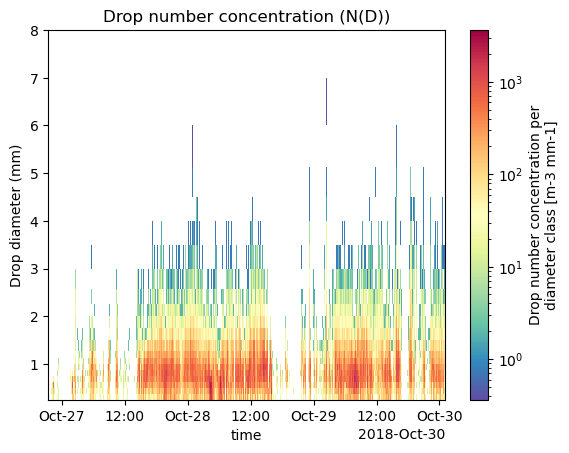

In [ ]:
ds_subset.disdrodb.plot_nd()

Now let's plot the derived rain rate estimate:

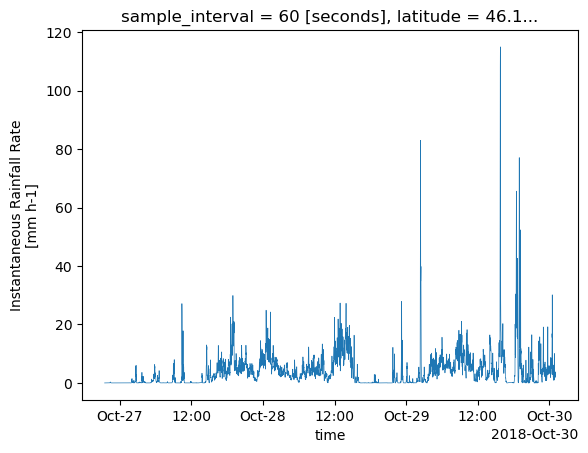

In [ ]:
ds_subset["R"].plot(linewidth=0.5)

Feel free to check out the other variables in the L2E product dataset.
For full details on all available variables and their definitions, see the DISDRODB L2E documentation [DISDRODB L2E documentation](https://disdrodb.readthedocs.io/en/latest/product_l2e.html).

## 9. Conclusion

You arrived at the end of this tutorial. Well done 👋👋👋 

At this point, you should be able to create the DISDRODB readers for your own stations and generate the DISDRODB products.

When you think your reader is ready for inclusion in the disdrodb software, please continue to read the [How to Contribute New Data to DISDRODB](https://disdrodb.readthedocs.io/en/latest/contribute_data.html#step-9-test-launching-disdrodb-l0-processing) guidelines.

Do not hesitate to open a [GitHub Issue](https://github.com/ltelab/disdrodb/issues) if you need any clarification. 

The DISDRODB team hope you enjoyed this tutorial!